# Analyzing CelebA Images: Fourier Transforms and Power Spectra
This notebook analyzes images from the CelebA dataset using Fourier transforms and computes their radial power spectra.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
from PIL import Image

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64 for faster processing
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
# Load CelebA dataset
# The dataset will be downloaded automatically if not present
dataset = torchvision.datasets.CelebA(
    root='./data',  # Data will be downloaded to this directory
    split='train',  # Use training split
    transform=transform,
    download=True
)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=917f4538-1a36-490f-a3fd-1f7f55994654
To: c:\Users\henhen724\Desktop\LabNotebooks\learning_diffusion_models\data\celeba\img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:13<00:00, 109MB/s] 
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: c:\Users\henhen724\Desktop\LabNotebooks\learning_diffusion_models\data\celeba\list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 36.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: c:\Users\henhen724\Desktop\LabNotebooks\learning_diffusion_models\data\celeba\identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 30.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: c:\Users\henhen724\Desktop\LabNotebooks\

In [5]:
def compute_fft(image):
    """Compute 2D FFT of an image."""
    # Convert to grayscale if RGB
    if image.shape[0] == 3:
        image = image.mean(dim=0)
    
    # Compute FFT
    fft = torch.fft.fft2(image)
    fft_shift = torch.fft.fftshift(fft)
    magnitude = torch.abs(fft_shift)
    
    return magnitude

In [6]:
def compute_radial_spectrum(magnitude):
    """Compute radial power spectrum from FFT magnitude."""
    h, w = magnitude.shape
    center_h, center_w = h // 2, w // 2
    
    # Create coordinate grid
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w))
    y = y - center_h
    x = x - center_w
    
    # Compute distances from center
    distances = torch.sqrt(x.float()**2 + y.float()**2)
    
    # Compute radial average
    max_radius = min(center_h, center_w)
    radial_spectrum = torch.zeros(max_radius)
    counts = torch.zeros(max_radius)
    
    for r in range(max_radius):
        mask = (distances >= r) & (distances < r + 1)
        radial_spectrum[r] = magnitude[mask].mean()
        counts[r] = mask.sum()
    
    return radial_spectrum


In [7]:
# Process a batch of images
def process_batch(batch):
    images = batch[0]  # Get images from batch
    
    # Process first image as example
    image = images[0]
    
    # Compute FFT
    fft_magnitude = compute_fft(image)
    
    # Compute radial spectrum
    radial_spectrum = compute_radial_spectrum(fft_magnitude)
    
    return image, fft_magnitude, radial_spectrum


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.827451].


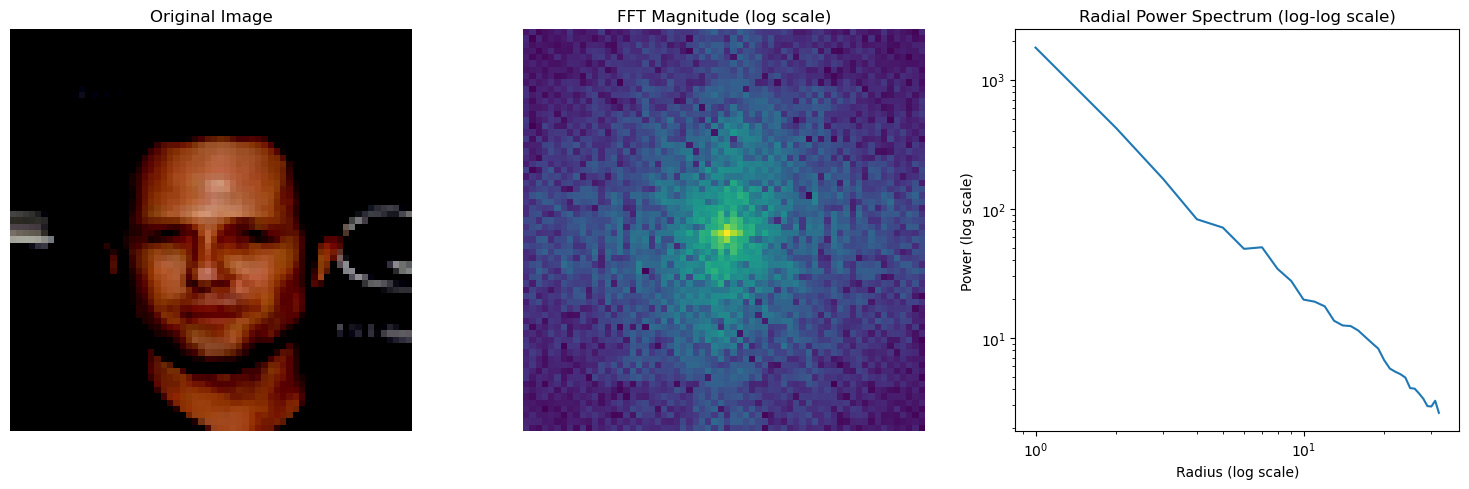

In [11]:
# Get a batch of images and process them
batch = next(iter(dataloader))
image, fft_magnitude, radial_spectrum = process_batch(batch)

# Plot results
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(131)
plt.imshow(image.permute(1, 2, 0).numpy())
plt.title('Original Image')
plt.axis('off')

# FFT magnitude
plt.subplot(132)
plt.imshow(torch.log1p(fft_magnitude).numpy(), cmap='viridis')
plt.title('FFT Magnitude (log scale)')
plt.axis('off')

# Radial spectrum
plt.subplot(133)
plt.loglog(range(1, len(radial_spectrum)+1), radial_spectrum.numpy())
plt.title('Radial Power Spectrum (log-log scale)')
plt.xlabel('Radius (log scale)') 
plt.ylabel('Power (log scale)')

plt.tight_layout()
plt.show()


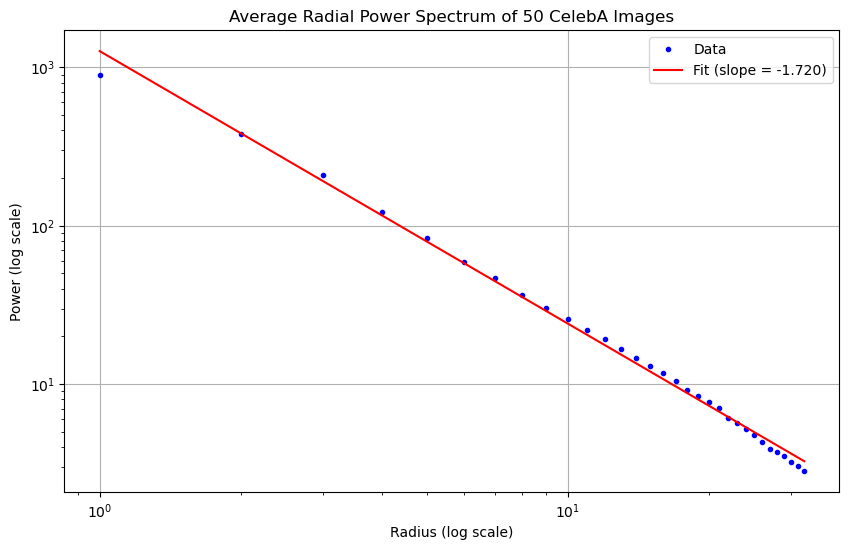

In [12]:
# Sample 50 random images and compute average spectrum
num_samples = 50
all_spectra = []

for _ in range(num_samples):
    batch = next(iter(dataloader))
    _, _, spectrum = process_batch(batch)
    all_spectra.append(spectrum.numpy())

# Convert to numpy array and compute mean
all_spectra = np.array(all_spectra)
mean_spectrum = np.mean(all_spectra, axis=0)

# Prepare data for fitting
x = np.log(np.arange(1, len(mean_spectrum) + 1))
y = np.log(mean_spectrum)

# Perform linear fit
slope, intercept = np.polyfit(x, y, 1)
fit_line = np.exp(intercept + slope * x)

# Plot results
plt.figure(figsize=(10, 6))
plt.loglog(range(1, len(mean_spectrum) + 1), mean_spectrum, 'b.', label='Data')
plt.loglog(range(1, len(mean_spectrum) + 1), fit_line, 'r-', 
          label=f'Fit (slope = {slope:.3f})')
plt.title('Average Radial Power Spectrum of 50 CelebA Images')
plt.xlabel('Radius (log scale)')
plt.ylabel('Power (log scale)')
plt.legend()
plt.grid(True)
plt.show()


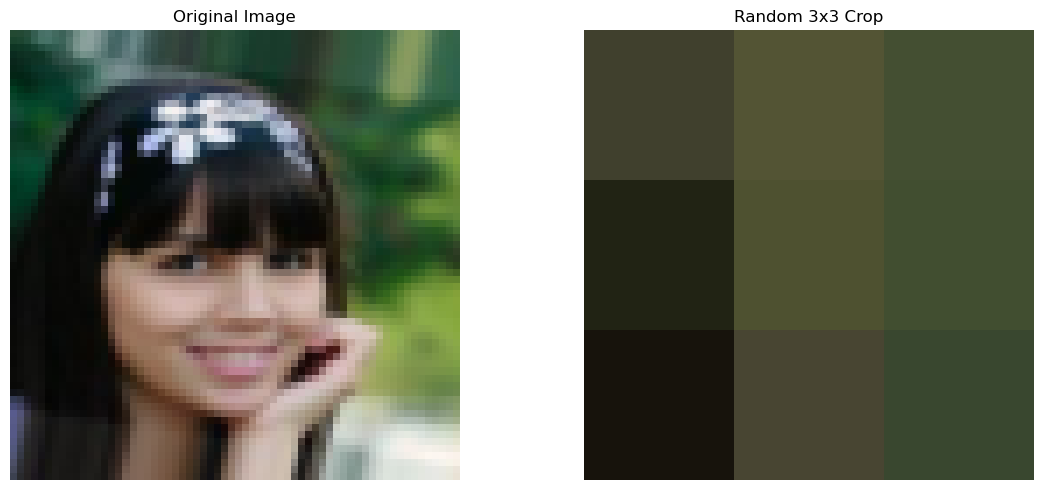

In [29]:
# Define random crop transform
class RandomCrop(torch.nn.Module):
    def __init__(self, crop_height, crop_width):
        super().__init__()
        self.crop_height = crop_height
        self.crop_width = crop_width
        
    def forward(self, img):
        # Check input is a torch tensor
        if not isinstance(img, torch.Tensor):
            raise TypeError("Input image must be a torch tensor")
            
        # Get full image dimensions
        # print(img.shape)
        _, h, w = img.shape
        
        # Generate random crop coordinates
        top = torch.randint(0, h - self.crop_height, (1,)).item()
        left = torch.randint(0, w - self.crop_width, (1,)).item()
        
        # Crop the image
        return img[:, top:top + self.crop_height, left:left + self.crop_width]

# Test the transform
batch = next(iter(dataloader))
img = batch[0][0] # Get first image from batch
# Create transform pipeline
random_crop = RandomCrop(3, 3)

# Apply transform
cropped_img = random_crop(img)

# Plot original and cropped images
plt.figure(figsize=(12, 5))

# Reverse normalization transform
denorm = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)

plt.subplot(121)
plt.imshow(denorm(img).permute(1,2,0).clamp(0,1))
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(denorm(cropped_img).permute(1,2,0).clamp(0,1))
plt.title('Random 3x3 Crop')
plt.axis('off')

plt.tight_layout()
plt.show()

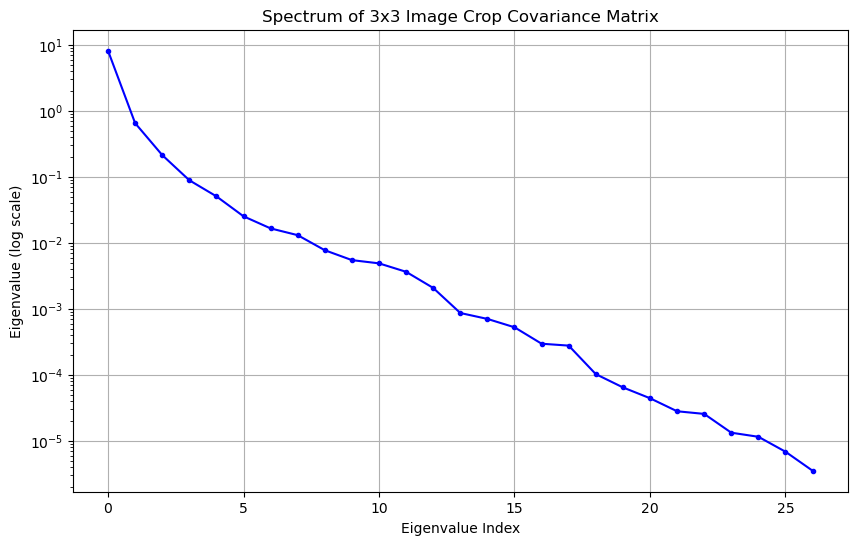

In [30]:
# Take 50 samples and collect n x n crops
n = 3  # Size of crops
num_samples = 50
crops = []

# Collect crops from random images
for i in range(num_samples):
    # Get random image from dataset
    idx = torch.randint(0, len(dataset), (1,)).item()
    img = dataset[idx][0]
    
    # Apply random crop
    crop = random_crop(img)
    
    # Flatten the crop into a vector
    crop_flat = crop.flatten()
    crops.append(crop_flat)

# Stack all crops into a matrix
crops = torch.stack(crops)

# Calculate mean and subtract it
mean_crop = torch.mean(crops, dim=0)
centered_crops = crops - mean_crop

# Calculate covariance matrix
cov_matrix = torch.mm(centered_crops.T, centered_crops) / (num_samples - 1)

# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)

# Sort eigenvalues in descending order
eigenvalues = eigenvalues.flip(0)

# Plot spectrum
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues.cpu().numpy(), 'b.-')
plt.yscale('log')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue (log scale)')
plt.title(f'Spectrum of {n}x{n} Image Crop Covariance Matrix')
plt.grid(True)
plt.show()


Average L2 distance between 3x3 crops: 3.7437


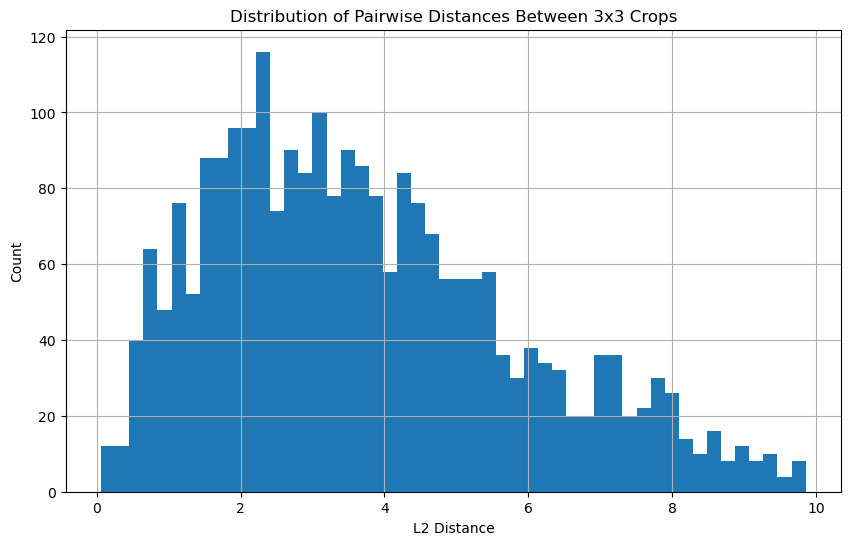

In [31]:
# Calculate pairwise distances between all crops
distances = torch.cdist(crops, crops)

# Get average distance (excluding self-distances which are 0)
mask = ~torch.eye(num_samples, dtype=bool)  # Mask to exclude diagonal
avg_distance = distances[mask].mean()

print(f"Average L2 distance between {n}x{n} crops: {avg_distance:.4f}")

# Plot histogram of distances
plt.figure(figsize=(10, 6))
plt.hist(distances[mask].cpu().numpy(), bins=50)
plt.xlabel('L2 Distance')
plt.ylabel('Count')
plt.title(f'Distribution of Pairwise Distances Between {n}x{n} Crops')
plt.grid(True)
plt.show()